# Reducing Crime

## Theodore Fong

# Introduction:

One of the primary concerns for any government is the safety and security of the citizens that live within its jurisdiction. Crime rate, or the ratio of crimes committed per person, is an important measure of safety within a given community. Therefore, local governments should seek to implement policy that lowers crime rates. Governments can control several factors relating to crime deterrents, such as how likely an individual is to be arrested for a crime, or how likely they are to be sentenced to a prison term once they have been convicted. We seek to determine the impacts of several different (government influenceable) variables have on a county's crime rate, and determine where government resources should be allocated in order to most effectively reduce crime rate. 

Our research question can be stated as follows: do the probability of arrest, the probability of conviction, the probability of a prison sentence, the average length of a prison sentence, and police per capita impact a county's crime rate? 

We will assess these factors both independently and jointly to help answer several sub-questions:

- Does increasing the probability of arrest, conviction, and a prison sentence decrease the crime rate (by deterring potential criminals)?
- Does lengthening prison sentences lower crime rate (again, by deterring potential criminals)?
- Does increasing police presence in a county reduce the crime rate?

Our null hypotheses are that these factors (which can be interpreted as "crime deterrents") have zero impact on crime rate. Either by rejecting or by failing to reject these null hypotheses, we will be able to make government policy recommendations about the appropriate (or inappropriate) use of government resources in order to target a reduction in crime rate.

# Data Loading, Cleaning, Exploration

The data we use in this report comes from the original study by Cornwell and Trumball, researchers from the University of Georgia and West Virginia University (C. Cornwell and W. Trumball (1994), “Estimating the Economic Model of Crime with Panel Data,” Review of Economics and Statistics 76, 360-366.). It provides important crime statistics from different North Carolina counties in 1994. 

In [1]:
raw_data <- read.csv("crime_v2.csv")

In [2]:
library(car)
library(lmtest)
library(sandwich)
library(stargazer)

Warning message:
"package 'car' was built under R version 3.5.3"Loading required package: carData
Warning message:
"package 'carData' was built under R version 3.5.2"Warning message:
"package 'lmtest' was built under R version 3.5.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.5.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'sandwich' was built under R version 3.5.3"Warning message:
"package 'stargazer' was built under R version 3.5.2"
Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [3]:
summary(raw_data)

     county           year        crmrte             prbarr       
 Min.   :  1.0   Min.   :87   Min.   :0.005533   Min.   :0.09277  
 1st Qu.: 52.0   1st Qu.:87   1st Qu.:0.020927   1st Qu.:0.20568  
 Median :105.0   Median :87   Median :0.029986   Median :0.27095  
 Mean   :101.6   Mean   :87   Mean   :0.033400   Mean   :0.29492  
 3rd Qu.:152.0   3rd Qu.:87   3rd Qu.:0.039642   3rd Qu.:0.34438  
 Max.   :197.0   Max.   :87   Max.   :0.098966   Max.   :1.09091  
 NA's   :6       NA's   :6    NA's   :6          NA's   :6        
        prbconv      prbpris           avgsen           polpc         
            : 5   Min.   :0.1500   Min.   : 5.380   Min.   :0.000746  
 0.588859022: 2   1st Qu.:0.3648   1st Qu.: 7.340   1st Qu.:0.001231  
 `          : 1   Median :0.4234   Median : 9.100   Median :0.001485  
 0.068376102: 1   Mean   :0.4108   Mean   : 9.647   Mean   :0.001702  
 0.140350997: 1   3rd Qu.:0.4568   3rd Qu.:11.420   3rd Qu.:0.001877  
 0.154451996: 1   Max.   :0.6000   Max

We can identify several important factors that government can control with policy through the dataset. These factors will be the primary variables of focus as we seek to make policy recommendations on reducing crime:

- prbarr: the probability of arrest (ratio of arrests to offenses in a given county)
- prbconv: the probability of conviction (ratio of convictions to arrests)
- prbpris: the probability of a prison sentence (ratio of convictions resulting in a prison sentence to total convictions)
- avgsen: the average length of a prison sentence 
- polpc: police per capita

In addition to these variables, there are several demographic variables a government cannot directly control, yet still may help explain crime rate in any given community.  After testing the variables that we view as the primary policy levers for reducing crime rate, we'll introduce these variables as an examination of robustness for our initial model.

- density: people per square mile
- pctmin80: percent minority (1980)
- pctymle: percent young male

The data set also includes other variables that may or may not relate to crime rate, such as economic-related variables like tax per capita or wage for different industries and geographic indicators.

An initial look at the data summary (above) suggests for data cleansing. First, there are six "NA" entries for each variable. We assume this means there are six empty observations we must remove from the dataset. Secondly, the variable "prbconv" is a string, which we will convert to numeric in order to run effective analysis. Finally, "prbarr" has a value greater that 1, which does not make theoretical sense. We will have to find this data point and remove the observation from our data set.

We address these problems with the data now:

In [4]:
data <- raw_data[complete.cases(raw_data), ]
dim(raw_data)
dim(data)

[1] 97 25

[1] 91 25

After removing the six "NA"s, we now have 91 observations, instead of the original 97 observations. 

In [5]:
data$prbconv <- (as.numeric(as.character(data$prbconv)))
summary(data$prbconv)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06838 0.34541 0.45283 0.55128 0.58886 2.12121 

After converting prbconv to numeric values, we thought that the data presented in a 0-100 scale may be easier for interpretation.  When creating a linear model we consider the impact of a unit change of 1%; this helps us avoid having to interpret the variable as the change we get from moving from 0 to 1.

In [6]:
data$prbconv <- data$prbconv * 100
data$prbarr <- data$prbarr * 100
data$prbpris <- data$prbpris * 100

We now need to inspect the anomaly in our prbarr variable, where a certain datapoint indicates a probability of arrest greater that 1 (or 100%, as we have now transformed the variable). We need to determine which county must be removed from the dataset.

In [7]:
data$county[data$prbarr >100]

[1] 115

In [8]:
data[data$county==115,]

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,...,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
51,115,87,0.0055332,109.091,150,50,20.7,0.00905433,0.3858093,28.1931,...,503.2351,217.4908,342.4658,245.2061,448.42,442.2,340.39,386.12,0.1,0.07253495


We then remove this observation.

In [9]:
vars2 <- names(data)
data2 <-data[vars2]
d <- subset(data2, county !=115)
dim(d)

[1] 90 25

Finally, our dataset has 90 observations after data cleansing and transformations. We now build a linear regression model that helps us determine the effects of different variables on crime rate.

# Model Building

Our variables of interest are those that a government can easily control through public policy at the local county and state level. Our model uses the following variables:

- prbarr (the probability of arrest, defined as the ratio of arrests made to crimes committed)
- prbconv (the probability of conviction, defined as the ratio of convictions to arrests)
- prbpris (the probability of a prison sentence, defined as the ratio of convictions resulting in a prison sentence to total convictions)
- avgsen (the average length of a prison sentence)
- polpc (police per capita)

We hypothesize that these variables have an impact on crime rate. The various probabilities are relevant because higher probabilities ought to deter criminal activity, like a community that professes to be "tough on crime" due to these high probabilities. A potential criminal may think twice before committing a crime, as they consider the likelihood they will be arrested, convicted, and given a prison sentence as a result. Conversely, a community where these probabilities are low, a potential criminal may think they have a stronger chance of committing a crime without repercussion, and thus commits a crime. Government policy could alter legal standards that would change these probabilities.

Average sentence length works similarly as a deterrent. We would expect that communities that tend to give longer prison sentences are "tougher on crime" to discourage illegal activity in their community. Government policy could alter legal standards that could lengthen or shorten the length of prison sentences.

The final variable, police per capita, is important to consider as a government allocates the use of police forces to most effectively deter criminal activity. We are interested if an increased police presence has a negative impact on crime rate. We must be cautious with causality here, as an increase in police per capita could actually be a response to high crime rate.

In summary, our null hypothesis for the model building will be that the individual regression coefficients are actually 0, indicating that the explanatory variables are not statistically relevant in explaining crime rates. The alternative hypothesis is that the linear model's individual regression coefficients are not 0, which would indicate that they are statistically relevant in a linear regression model in explaining crime rates.

## EDA on outcome and explanatory variables:

We begin by inspecting the distribution of our outcome variable: crime rate.

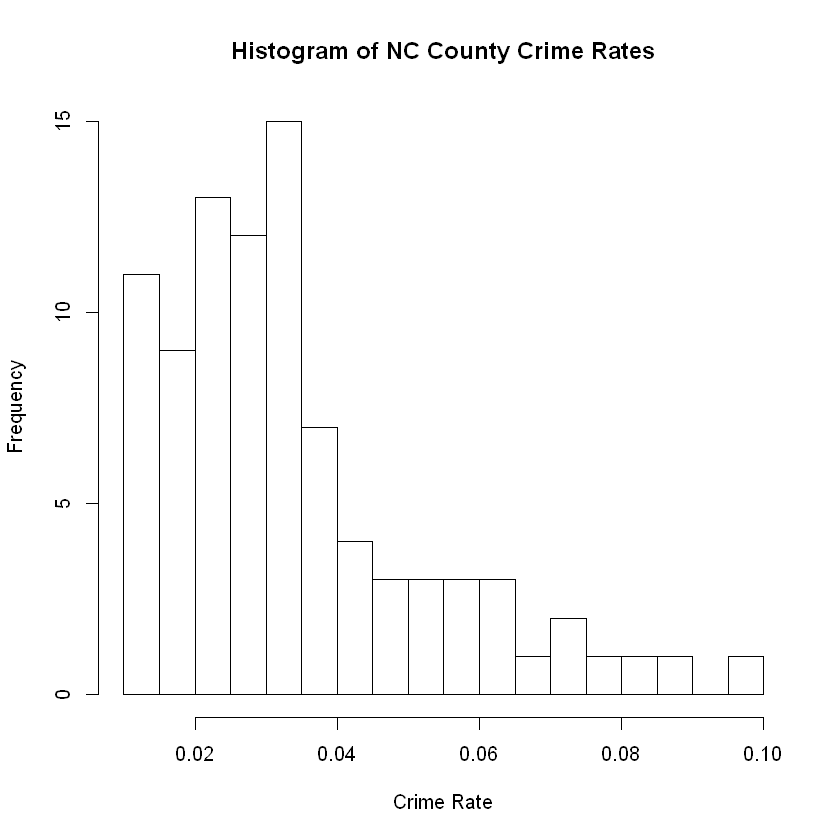

In [10]:
hist(d$crmrte, breaks=20, xlab= "Crime Rate", 
     main = "Histogram of NC County Crime Rates")

There is a peak around 0.03 (also the median, from the initial summary), with a heavy positive skew. This indicates there are more communities suffering from higher crime rates than the median and mean. While taking the log of this variable may produce a more normal distribution, interpreting the log of crime rate does not seem meaningful.

We next look at the distributions of our predictor variables, as well as their relationship with our outcome variable. We begin with the probability of arrest.

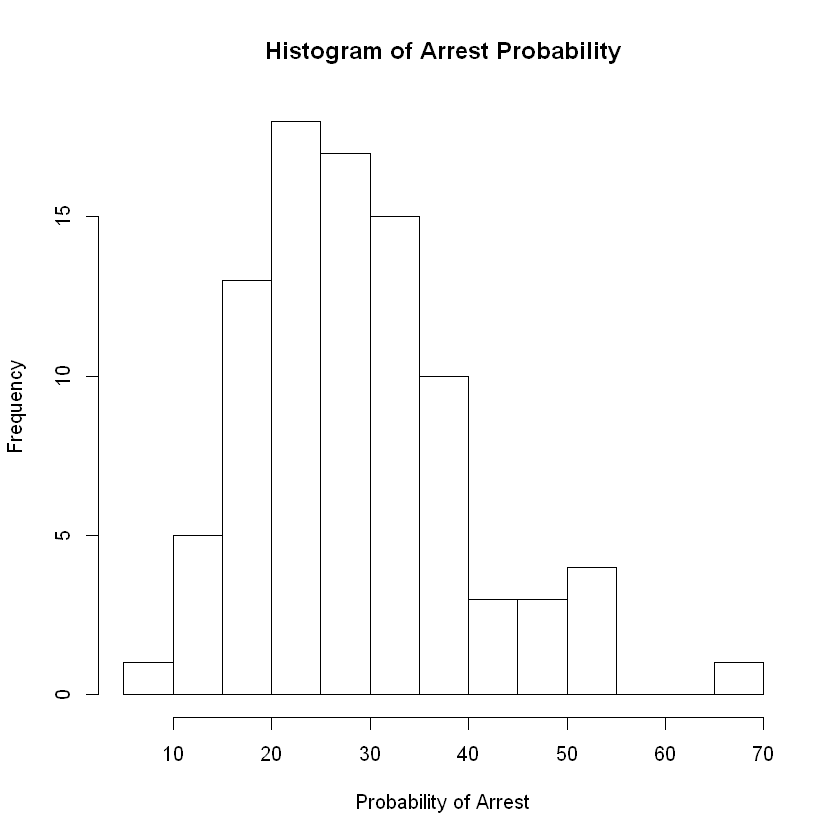

In [11]:
hist(d$prbarr, breaks=20, xlab= "Probability of Arrest", 
     main = "Histogram of Arrest Probability")

We notice a peak around twenty percent, with a slight positive skew. The range is rather wide; while there is a county with a probability of arrest lower that ten percent, there is also a county with a probability of arrest nearing seventy percent (a bit of an outlier).

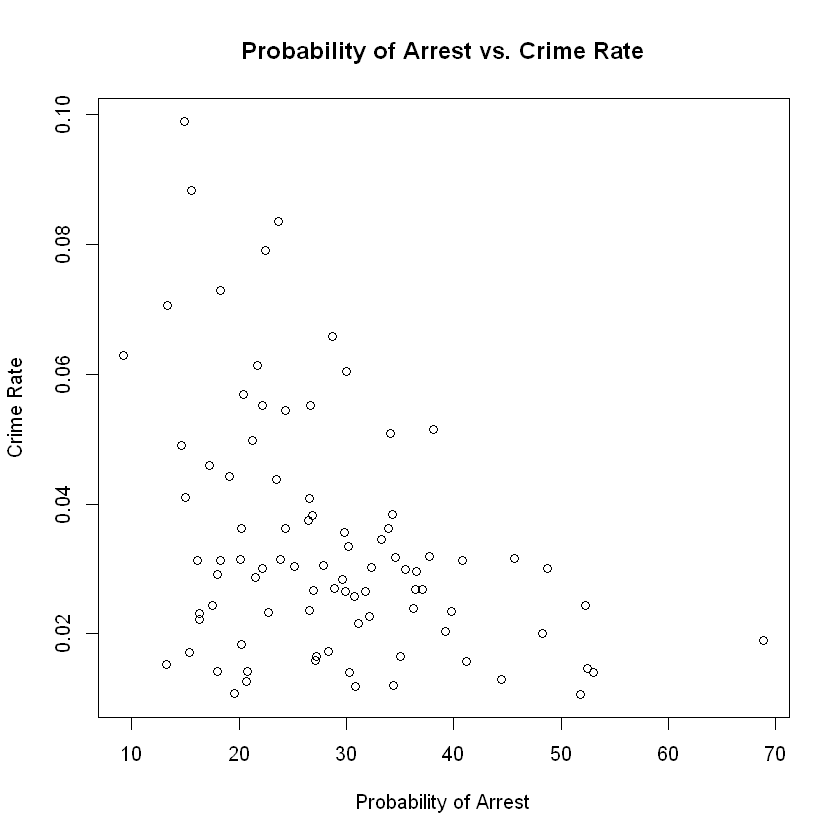

In [12]:
plot(d$prbarr, d$crmrte, xlab="Probability of Arrest", ylab="Crime Rate",
           main="Probability of Arrest vs. Crime Rate")

The scatterplot shows a negative relationship between the probability of arrest in a county and that county's crime rate. An increase in the probability of arrest is associated with a decrease in the crime rate.

We now consider our next predictor variable, the probability of conviction.

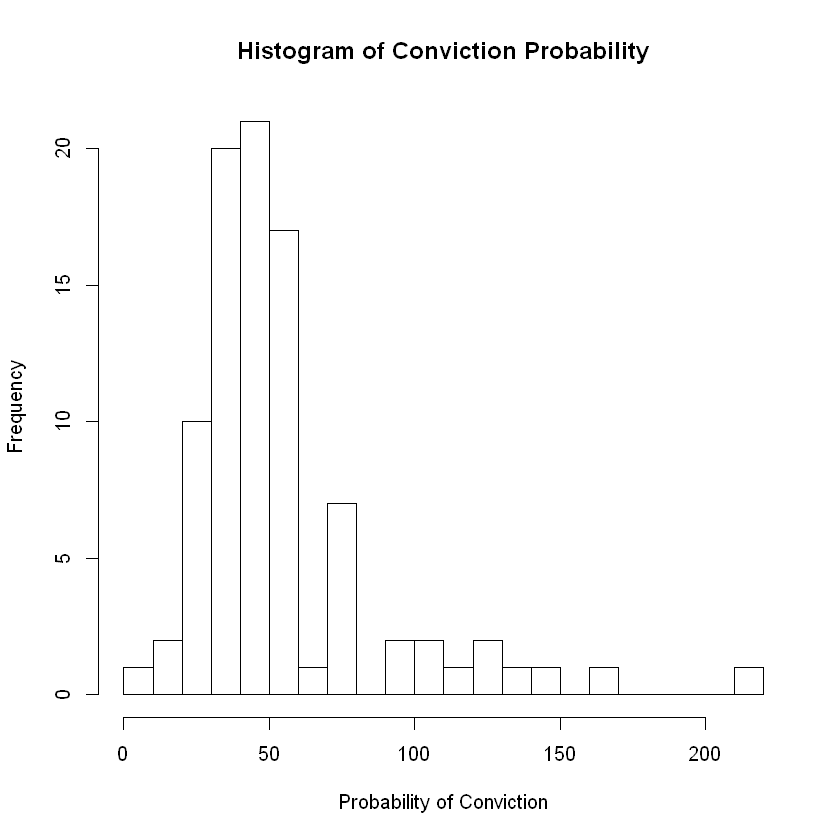

In [13]:
hist(d$prbconv, breaks=20, xlab= "Probability of Conviction", 
     main = "Histogram of Conviction Probability")

The distribution for the probability of conviction is mostly distributed from thirty to sixty percent.  A concern is the number of counties with a probability of conviction above one hundred percent.  The description of prbconv is that it is "proxied by the ratio of convictions to arrests".  Some cursory research into the topic revealed that its possible for a person to be convicted without going through a formal custodial arrest.  Therefore, we've elected to keep observations with greater than 100 in but will proceed with both the understanding that this variable is only a proxy for probability of conviction and that the range of this variable is not constrained to values less than a hundred.  

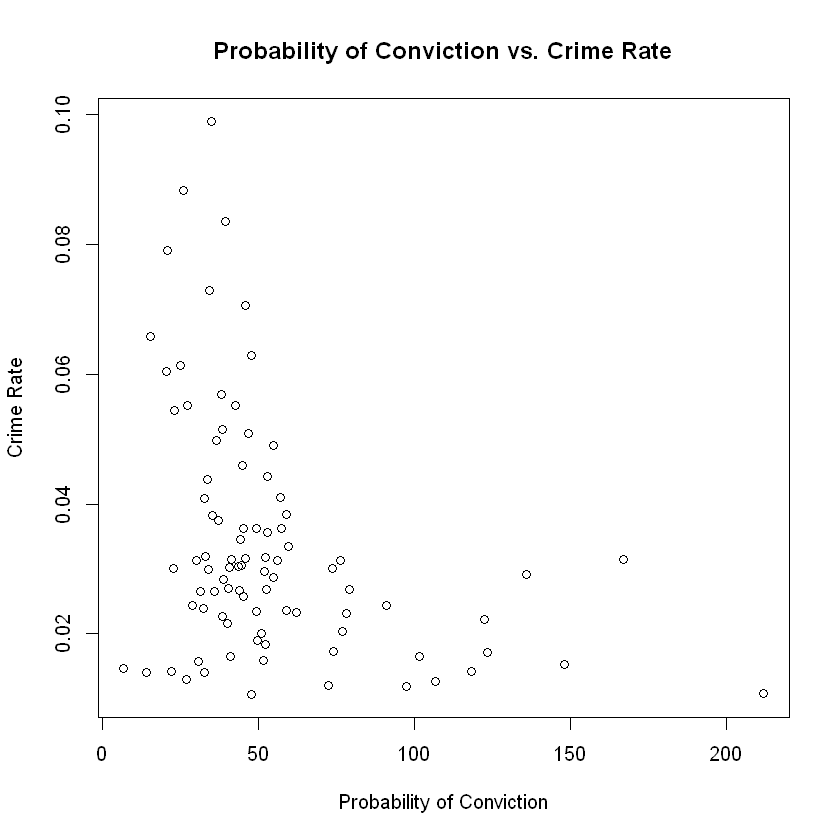

In [14]:
plot(d$prbconv, d$crmrte, xlab="Probability of Conviction", ylab="Crime Rate",
           main="Probability of Conviction vs. Crime Rate")

Similarly to the probability of arrest, there seems to be a negative relationship here. An increase in the probability of conviction is associated with a decrease in the crime rate.

We move on to consider our next variable: the probability of a prison sentence.

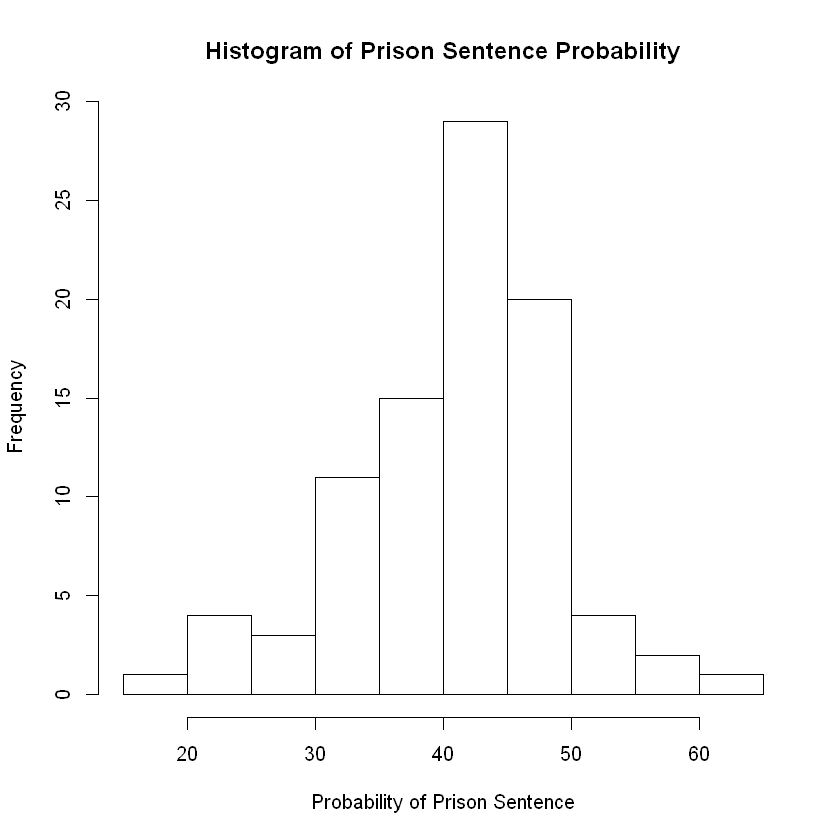

In [15]:
hist(d$prbpris, breaks=15, xlab= "Probability of Prison Sentence", 
     main = "Histogram of Prison Sentence Probability")

We notice a peak in the low forties, and possibly a slight negative skew. There does not appear to be anything irregular about the distribution.

We now consider the relationship between the probability of a prison sentence and crime rate.

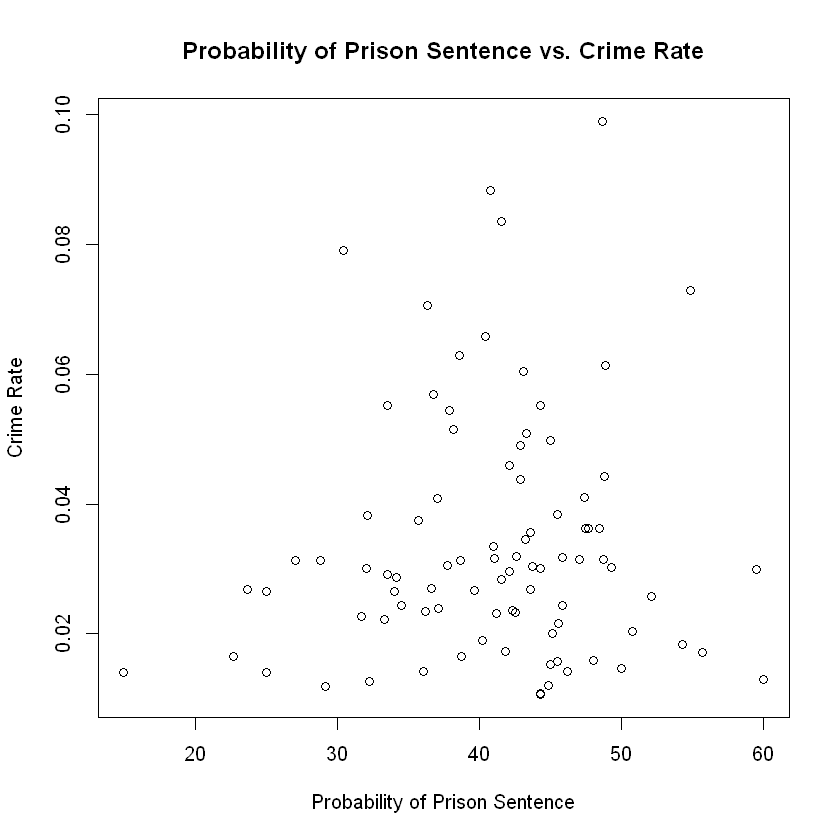

In [16]:
plot(d$prbpris, d$crmrte, xlab="Probability of Prison Sentence", ylab="Crime Rate",
           main="Probability of Prison Sentence vs. Crime Rate")

It is difficult to identify a linear relationship based on this scatterplot. 

We now move on to our next predictor variable, average sentence length.

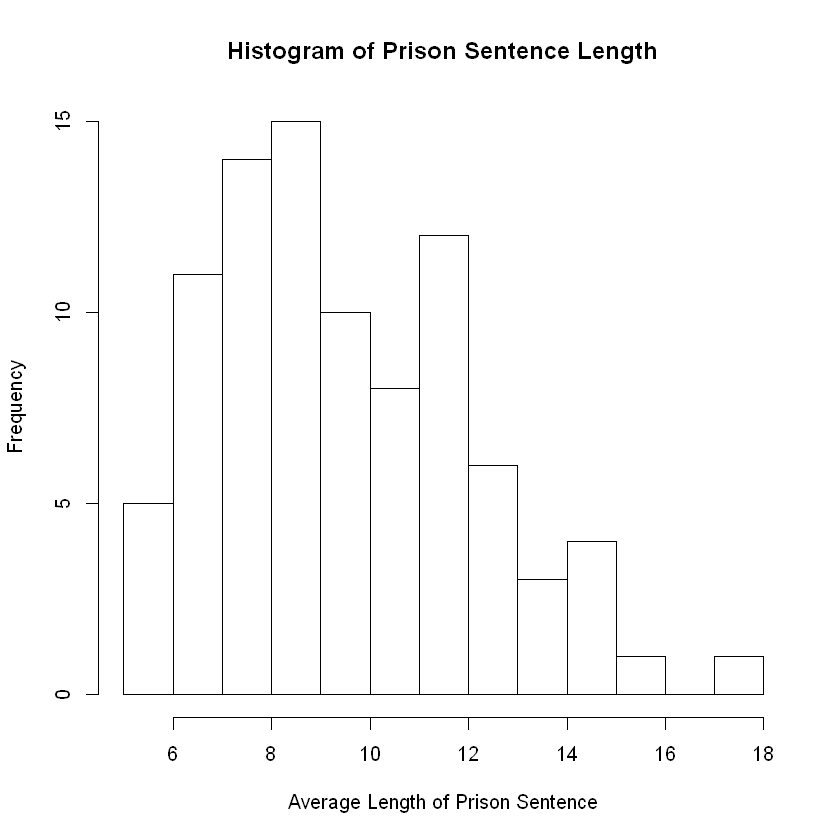

In [17]:
hist(d$avgsen, breaks=10, xlab= "Average Length of Prison Sentence", 
     main = "Histogram of Prison Sentence Length")

We notice a peak around 8 days with a positive skew, and another slight peak around 12 days.

We now analyze the relationship between average prison sentence length and crime rate.

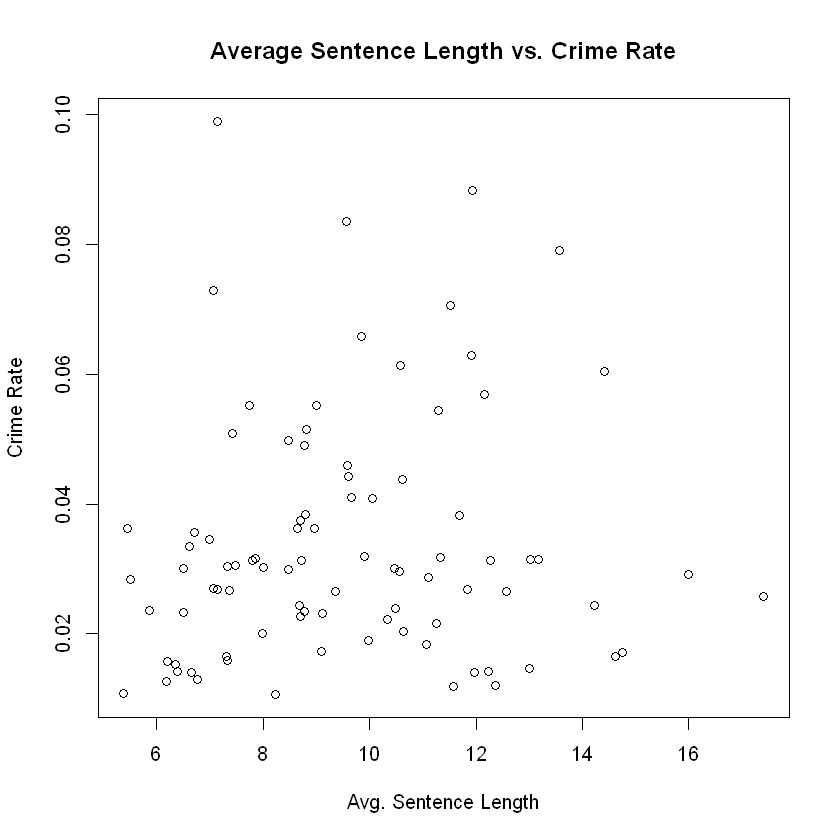

In [18]:
plot(d$avgsen, d$crmrte, xlab="Avg. Sentence Length", ylab="Crime Rate",
           main="Average Sentence Length vs. Crime Rate")

Again, it is difficult to determine a linear relationship between the two variables on our scatterplot, though there may be an indication of a slight positive relationship. 

Finally, we turn to our last predictor variable, police per capita.

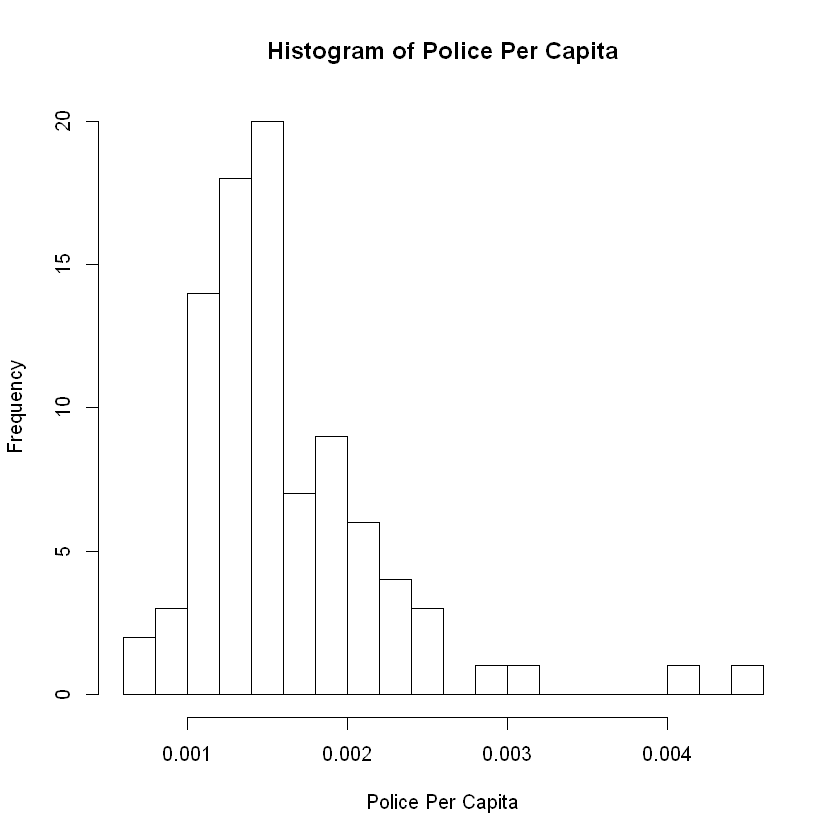

In [19]:
hist(d$polpc, breaks=15, xlab= "Police Per Capita", 
     main = "Histogram of Police Per Capita")

We notice a positive skew, with a peak around 0.0015 and several outliers greater that 0.004. This indicates some counties have a very large police presence, given the overall population of the county, in comparison with the rest of the state.

Let us consider the relationship between police per capita and crime rate.

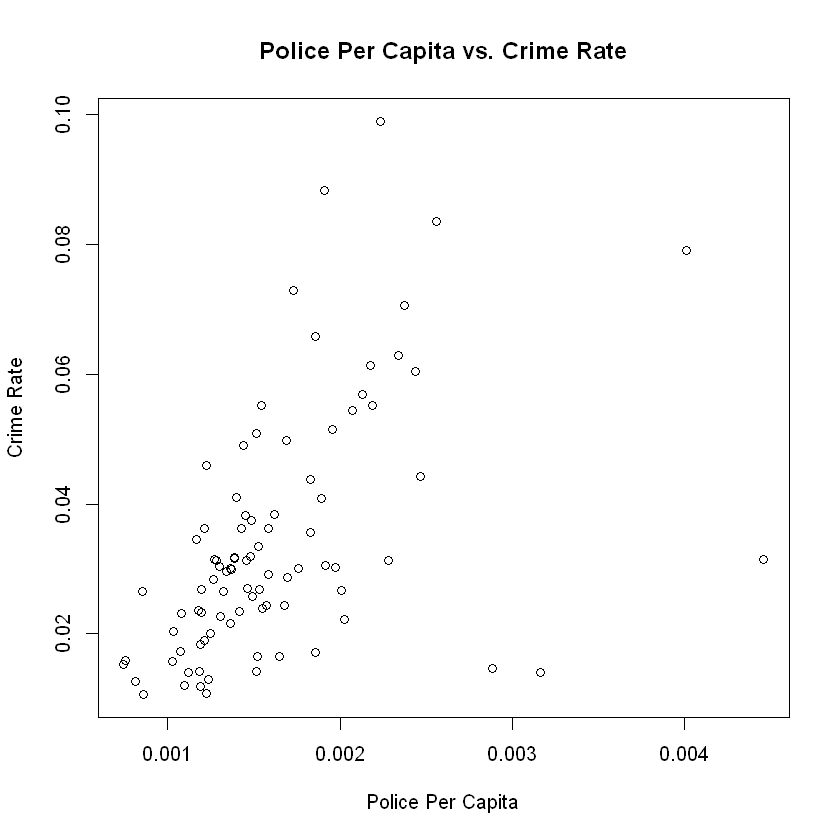

In [20]:
plot(d$polpc, d$crmrte, xlab="Police Per Capita", ylab="Crime Rate",
           main="Police Per Capita vs. Crime Rate")

We notice a positive relationship between police per capita and crime rate: an increase in police per capita is associated with an increase in crime rate. (Again, we are cautious about claiming causality here, as counties may increase police per capita in response to a high crime rate, rather than a high crime rate being a result of an increased police presence).

After this brief exploration to get an understanding of our primary variables of concern, we are now prepared to build our base linear regression model.

# Regression Model: Base

We now create our initial linear model for the parameters of interest. Our null hypothesis is that none of the explanatory variables are relevant to predicting crime rate through linear regression, while our alternative hypothesis is that these variables are relevant.

In [21]:
model1 <- lm(crmrte ~ prbarr + prbconv + prbpris + avgsen + polpc, data=d)

## Checking the CLM assumptions for our base model

### MLR.1: Linear in parameters

Our model is set up linearly, following the standard form
$$ y = \beta_0 + \beta_1 x_1 + ... + \beta_k x_k + u $$

### MLR.2: Random Sampling

We must assume our data points were drawn randomly and are iid.

### MLR.3: No perfect multicollinearity

We can test for multicollinearity by looking at the Variance Inflation Factors of our model. If any of our variables have a VIF near 4, then we will have found evidence of multicollinearity.

In [22]:
vif(model1)

prbarr  prbconv  prbpris   avgsen    polpc 
1.141246 1.130693 1.031949 1.128209 1.133225

All of our VIFs are close to one, indicating we are fine with our assumption that there is limited multicollinearity in our model, and certainly no perfect multicollinearity.

### MLR.4: Zero-conditional Mean

To test the zero-conditional mean assumption, we call the Residuals vs. Fitted plot of our model.

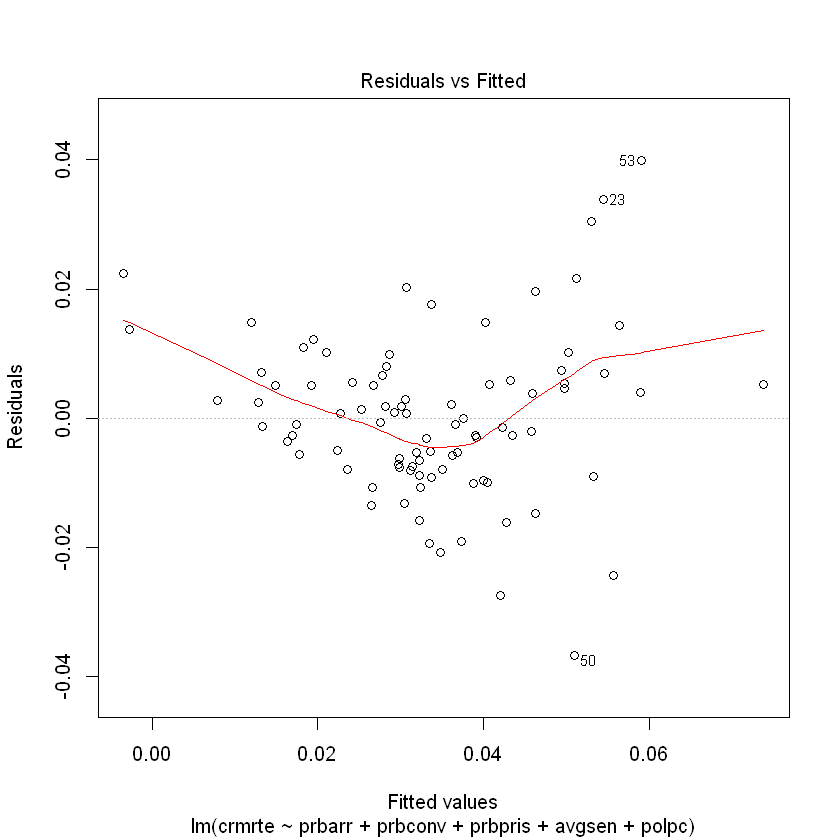

In [23]:
plot(model1, which = 1)

To meet the zero-conditional mean assumption, we would expect to see the scatterplot fitted around 0. This is not the case here, and we can see the mean line begins well above 0, dips down below 0, and then takes off again to be greater than 0, suggesting we are violating the zero mean condition and our estimated parameter coefficients may be biased.

With a sample size greater than 30 (recall we have data from 90 counties), we rely on OLS asymptotics in response to our violated zero-conditional mean assumption. If we set aside causality and look only for the best-fit line, exogeneity tells us our parameter estimates are consistent.

### MLR.5: Homoskedasticity

The Residuals vs. Fitted plot also suggests that we may be violating the homoskedasticity assumption. To meet the homoskedasticity assumption, we expect each vertical cross-section of the data points in the plot to be the same thickness. This is not the case as the variance on the left side is much smaller then the variance on the right and thus, we will likely need to correct our model for heteroskedasticity. We further analyze the Scale-Location plot to check for heteroskedasticity.

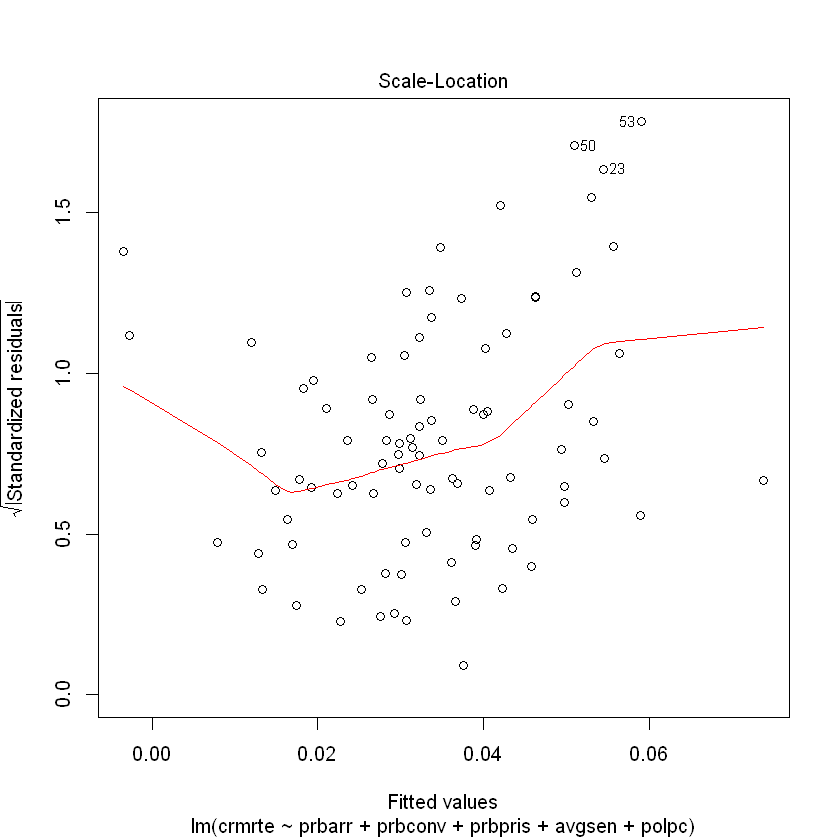

In [24]:
plot(model1, which = 3)

If we had homoskedasticity, we would expect the data points to track a flat horizontal line. This is not happening, again suggesting we have heteroskedasticity. We will have to use heteroskedasticity robust standard errors for our model.

### MLR.6: Normal error term

We look at a histogram of our error terms and run a shapiro test (with the null hypothesis that the residuals are normally distributed) to check this assumption:


	Shapiro-Wilk normality test

data:  model1$residuals
W = 0.97786, p-value = 0.1277


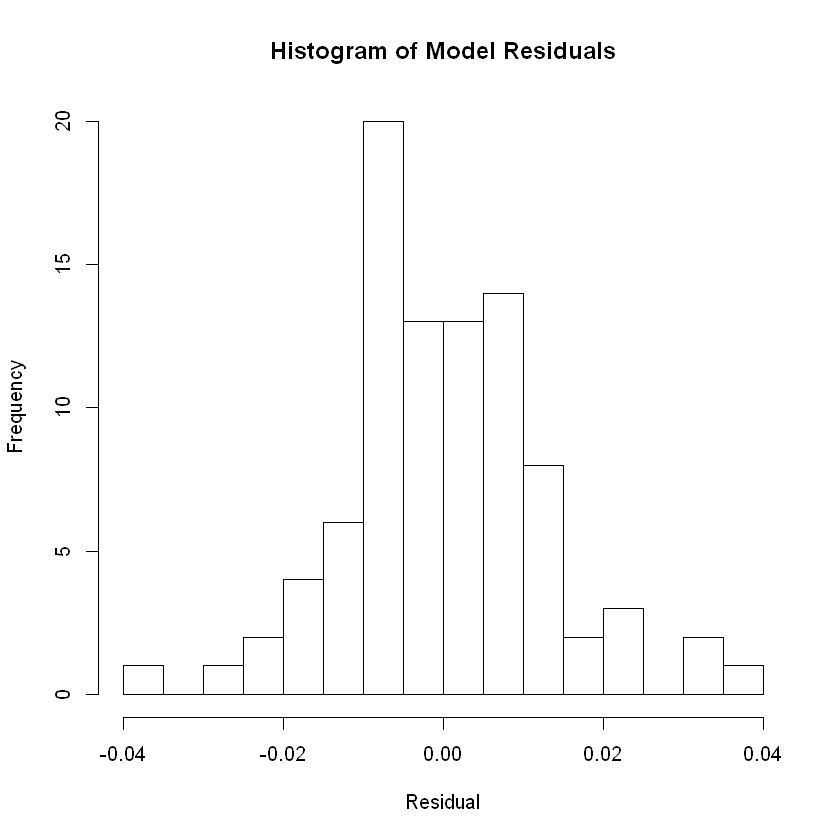

In [25]:
hist(model1$residuals, breaks= 12, main="Histogram of Model Residuals", 
     xlab="Residual")
shapiro.test(model1$residuals)

Visually, it appears that our residuals are close to normally distributed about 0 (with a peak slightly below 0). The shapiro test similarly fails to reject the null hypothesis that the residuals are normally distributed (with a p-value of 0.12). Thus, we have not violated the assumption.

### Check for Influential Points

In addition to our CLM assumptions, we also examine if there are points in our data set with high influence (high leverage and a large residual) on our regression. We will do this by looking at the plot of Residuals vs. Leverage, and seeing if any of our points have a great Cook's distance. Any point with a Cook's distance greater than 1 will require further inspection.

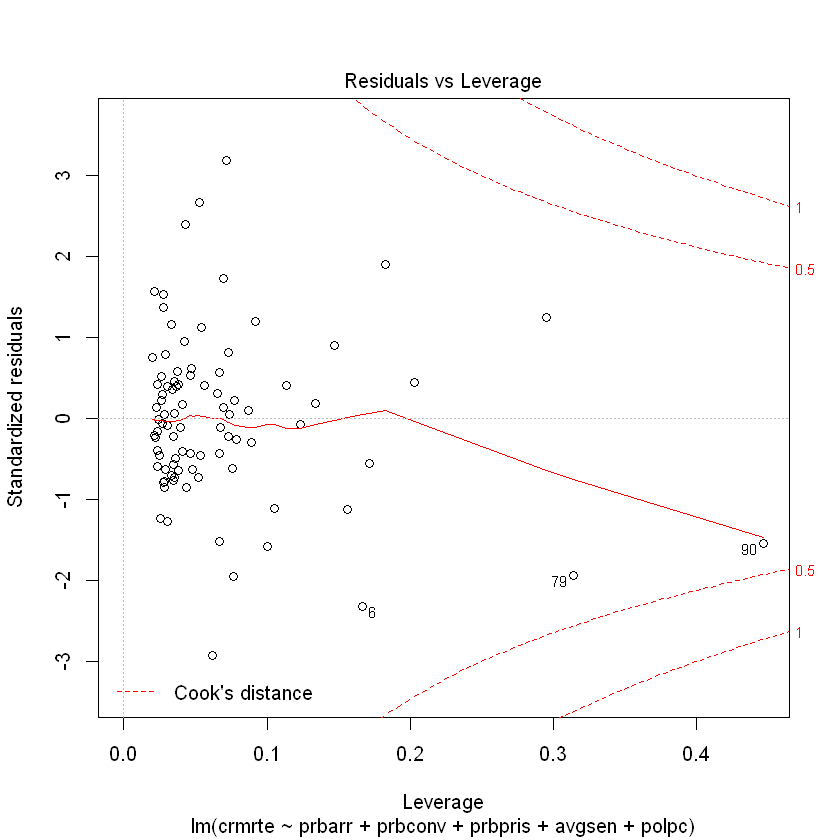

In [26]:
plot(model1, which = 5)

Our residuals vs. leverage plot indicates we do not have points with high influence that we should be concerned about.

We are now ready to analyze the results of our regression model.

## Interpreting Results (Base model)

Below we look at the parameter coefficients and standard errors for our model, adjusted for heteroskedasticity by giving the model a new variance-covariance matrix: "vcovHC" (for variance-covariance heteroskedasticity consistent).

In [27]:
se.model1 <- sqrt(diag(vcovHC(model1)))

stargazer(model1, type="text", keep.stat=c("n", "adj.rsq"), single.row=TRUE,
         se = list(se.model1), star.cutoffs = c(0.05, 0.01, 0.001))


                  Dependent variable:     
             -----------------------------
                        crmrte            
------------------------------------------
prbarr            -0.001*** (0.0002)      
prbconv           -0.0003*** (0.0001)     
prbpris             0.0001 (0.0002)       
avgsen              -0.0003 (0.001)       
polpc              12.197** (3.932)       
Constant            0.048** (0.017)       
------------------------------------------
Observations              90              
Adjusted R2              0.516            
Note:        *p<0.05; **p<0.01; ***p<0.001


We first note the first two significant results for our parameter coefficients- those for prbarr (probability of arrest) and prbconv (probability of conviction).

The sign of these two probabilities are negative, indicating that increasing the probability of arrest or the probability of conviction (while holding all other factors constant) will indeed reduce the crime rate.

The size of the effect is also important to consider: An increase in the probability of arrest of a single percentage point will decrease the crime rate by 0.001, and an increase in the probability of conviction of a single percentage point will decrease the crime rate by 0.0003. Under this model, the government should undergo a further cost/benefit analysis to determine if allocating its resources to increase these probabilites is worth the payoff.

The coefficients on prbpris and avgsen are not statistically significant, so we fail to reject the null hypothesis that these individual coeffecients are actually 0.

We next question whether or not these variables (prbpris and avgsen) are jointly significant. We run a linear hypothesis test with the null hypothesis test that both these parameter coefficients are equal to zero. If our result is not statistically signifant, we have reason to believe we can remove these variables from our model.

In [28]:
linearHypothesis(model1, c("prbpris=0", "avgsen=0") , vcov=vcovHC)

Res.Df,Df,F,Pr(>F)
86,NA,NA,NA
84,2,0.3726652,0.690029


With a p-value of 0.69, we fail to reject the null hypothesis that both coefficients are equal to 0. We now have reason to remove the variables from our model, but we elect to keep them as we continue to build our model (including additional variables). 

The statistically significant estimated coefficient on police per capita is a noteworthy calculation--it is positive, indicating that an increase in police per capita is associated with an increase in crime rate.  Misinterpreted, readers would use argue to decrease the size of the police force in counties with high crime rates. We do not recommend such action based on our analysis thus far. We have reason to believe there is omitted variable bias. Police per capita is likely higher in areas with demographic factors associated with higher crime rates. Because of these correlations, the omitted variable bias would be positive, meaning we have overestimated the parameter coefficient for police per capita. We seek to address this issue as we build upon our base model in subsequent models.

Finally, we note an adjusted R-squared value of 0.516 for our base model, informing us the explanatory variables in our model account for roughly 52% of the variation in crime rate.

While we cannot claim causality, the results of our linear regression base model allow us to return and consider our original research question (and subquestions): 

Do the probability of arrest, the probability of conviction, the probability of a prison sentence, average length of a prison sentence, and police per capita impact the crime rate?
- Does increasing the probability of arrest, conviction, and a prison sentence decrease the crime rate (by deterring potential criminals)?

From this regression model, we reject the null hypothesis that the parameter coefficients of the probability of arrest and the probability of conviction are equal to zero. Increases in each of these two probabilities are associated with decreases in crime rate. 

We fail to reject the null hypothesis that the parameter coefficient for the probability of a prison sentence is equal to zero. 

- Does lengthening prison sentences lower crime rate (again, by deterring potential criminals)?

From this regression model, we fail to reject the null hypothesis that the parameter coefficient of average sentence length is equal to zero. In regards to government policy, we are not able to recommend increasing sentence lengths as a measure to reduce crime rate.

- Does increasing police presence in a county reduce the crime rate?

From this regression model, we reject the null hypothesis that the parameter coefficient of police per capita is equal to zero. However, police per capita appears to be positively correlated with crime rate.  Because of this, we suspect there may be some omitted variable bias and plan to further test the robustness of this relationship as we add more variables in our next two models.

For a better understanding of crime, we seek to build upon our base model and incorporate other demographic factors we believe will influence our outcome variable of interest.

### Regression Model: Second Model

Building off our initial model, we wish to examine some other demographic explanatory variables: 
- density: people per square mile
- pctmin80: percent minority (1980)
- pctymle: percent young male

Governments can indirectly control these variables through public policy incentives. Therefore, we added these demographic variables as controls in our second model.

In [29]:
model2 <- lm(crmrte ~ prbarr + prbconv + prbpris + avgsen + polpc +
            density + pctymle + pctmin80, data=d)

## Checking the CLM assumptions for our second model

### MLR.1: Linear in parameters

Our second model is still linear, following the standard form
$$ y = \beta_0 + \beta_1 x_1 + ... + \beta_k x_k + u $$

### MLR.2: Random Sampling

We continue to assume our data points were drawn randomly and are iid.

### MLR.3 No perfect multicolinearity

As in our first model, we can test for multicollinearity by looking at the VIF of our model.

In [30]:
vif(model2)

prbarr  prbconv  prbpris   avgsen    polpc  density  pctymle pctmin80 
1.516012 1.386197 1.067681 1.136738 1.257403 1.438032 1.126678 1.102938

The VIFs for each of our variables do not provide evidence of multicollinearity, as all values  are close to 1 and well below 4.

### MLR.4: Zero-conditional Mean

To test the zero-conditional mean assumption, we call the Residuals vs. Fitted plot of our model.

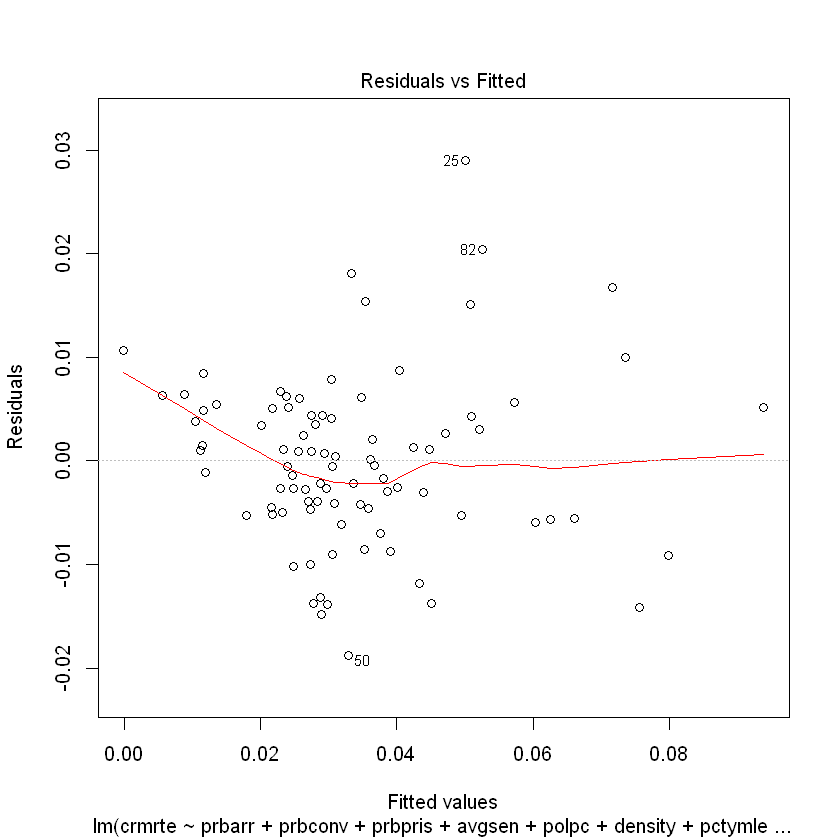

In [31]:
plot(model2, which = 1)

To meet the zero-conditional mean assumption, we would expect to see the scatterplot fitted around 0. While the red smoothing curve representing the residual mean begins above zero for smaller fitted values, it does begin to track zero for fitted values greater than (roughly) 0.02. This is a great improvement over our base model, which had a clear violation of the zero-conditional mean assumption. 

While the slight bump in the mean for small fitted values may indicate a slight violation of our assumption, we still have a sample size greater than 30 (recall we have data from 90 counties),  allowing us to rely on OLS asymptotics, as we did for our base model.

### MLR.5: Homoskedasticity

The Residuals vs. Fitted plot shows a smaller vertical band on the left side, then the right side, so the variance in the distribution is not equal. Therefore, we analyze the Scale-Location plot of our model to check for heteroskedasticity.

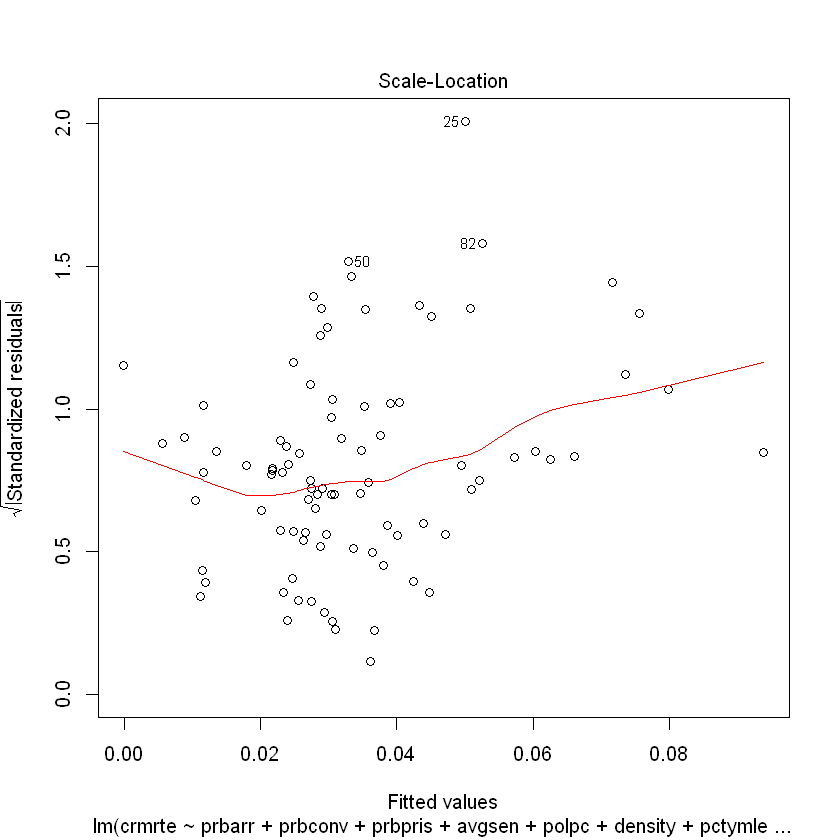

In [32]:
plot(model2, which = 3)

As we noted previously, we would expect the data points to track a flat horizontal line if we had homoskedasticity. While the points on this plot track a flatter line than they did for our base model (as shown by the red smoothing curve), we still see a large amount of scatter indicated heteroskedasticity. Ae before, we will use heteroskedasticity robust standard errors for this model.

### MLR.6 Normal Error Term

We analyze the histogram of our model residuals to verify they are normally distributed. We simultaneously run a shapiro test to check for normality (again with a null hypothesis that the residuals are indeed normally distributed).


	Shapiro-Wilk normality test

data:  model2$residuals
W = 0.97239, p-value = 0.05221


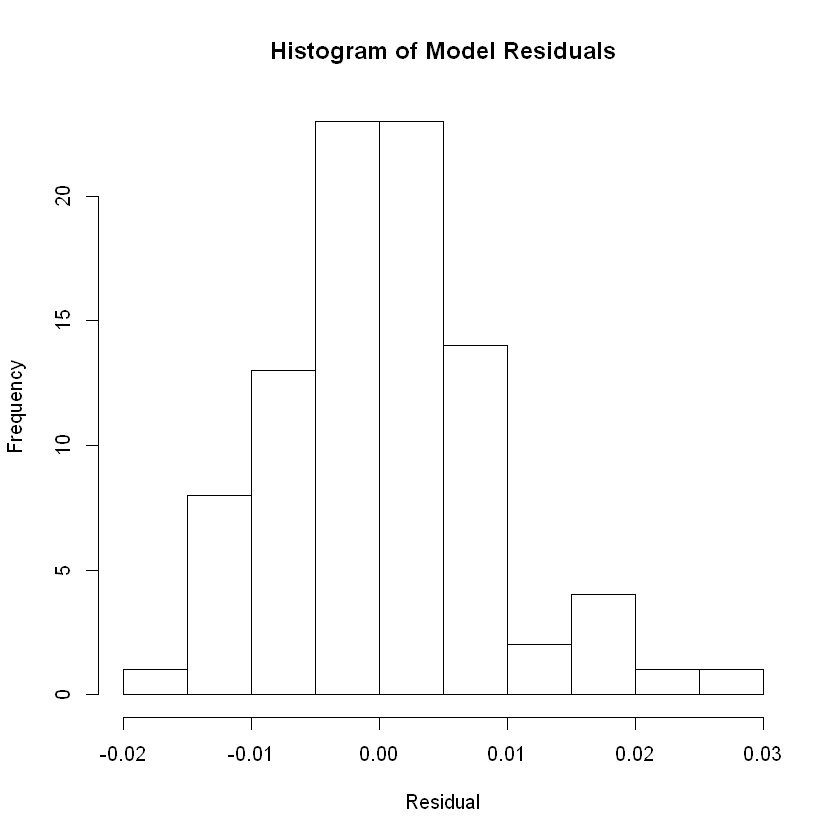

In [33]:
hist(model2$residuals, breaks= 12, main="Histogram of Model Residuals", 
     xlab="Residual")
shapiro.test(model2$residuals)

The histogram shows the distribution of residuals has a slight positive skew. The shapiro test also calculates a p-value of 0.05, so we narrowly fail to reject the null hypothesis that the residuals are normally distributed. Therefore, we do not have evidence this assumption has been violated.

### Check for Influential Points

As in our first model, we check for influential points through Cook's distance.

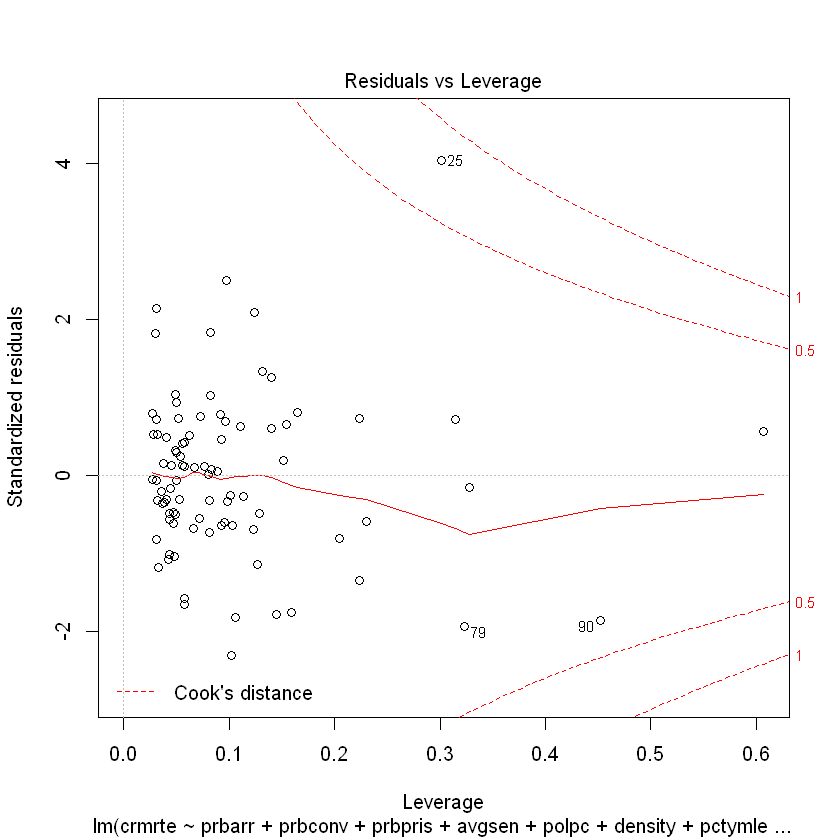

In [34]:
plot(model2, which = 5)

While one data point has Cook's distance greater than 0.5, none have values greater than 1. At this point we do not need to be concerned about points with high influence in our model.

## Interpreting Results (Second Model)

We now turn to the estimated parameter coefficients and their (heteroskedasticity robust) standard errors of our second model, and compare them to those of our base model.

In [35]:
# Adjusting for heteroskedacity.
se.model2 <- sqrt(diag(vcovHC(model2)))

stargazer(model1, model2,
          type="text", keep.stat=c("n", "adj.rsq"), se=list(se.model1,
          se.model2), single.row=TRUE, star.cutoffs = c(0.05, 0.01, 0.001))


                       Dependent variable:           
             ----------------------------------------
                              crmrte                 
                     (1)                 (2)         
-----------------------------------------------------
prbarr       -0.001*** (0.0002)   -0.001*** (0.0001) 
prbconv      -0.0003*** (0.0001) -0.0002*** (0.00005)
prbpris        0.0001 (0.0002)    -0.00003 (0.0001)  
avgsen         -0.0003 (0.001)     -0.0002 (0.0004)  
polpc         12.197** (3.932)      7.974 (4.543)    
density                            0.006*** (0.001)  
pctymle                             0.064 (0.052)    
pctmin80                          0.0004*** (0.0001) 
Constant       0.048** (0.017)     0.030** (0.012)   
-----------------------------------------------------
Observations         90                   90         
Adjusted R2         0.516               0.788        
Note:                   *p<0.05; **p<0.01; ***p<0.001


We note that the estimated coefficients for prbarr and prbconv are almost the same (within the standard error) as in our base model and are still statistically significant at the 0.1% level. The coefficients for prbpris and avgsen remain statistically insignificant.

The estimated coefficient for police per capita drops (although estimates from the two different models are within the standard errors of each other). In our second model, the coefficient for police per capita is no longer statistically significant, this change indicates some relationship between police per capita and our newly included demographic control variables.  Unlike the other variables, polpc does not possess robustness required with new regressor variables.

The estimated coefficients for density and percent minority are both significant at the 0.1% level. While this is not immediately actionable for government policy, it is important to recognize these factors as important controls in our regression model. Areas with higher population density and areas with a higher proportion of minorities are associated with higher crime rates (as both estimated coefficients are positive).

The coefficient for percent young male is positive, yet not statistically significant. As we continue to tinker with our model, we examine whether or not police per capita and percent young male may be related in some way, and therefore jointly significant in our regression model, despite the fact that both are individually statistically insignificant. To further examine, we run a joint significance test with the two variables, with the null hypothesis that the coefficients of both parameters are equal to zero.

In [36]:
linearHypothesis(model2, c("polpc=0", "pctymle=0") , vcov=vcovHC)

Res.Df,Df,F,Pr(>F)
83,NA,NA,NA
81,2,4.285531,0.01701573


With a p-value of 0.017, we reject the null hypothesis at 5% significance level that both parameter coefficients are equal to zero. The variables are jointly significant. There must be some relationship between police per capita and percent young male that is important in our regression. 

By testing our initial model with more variables, we could test for robustness.  We want to make policy proposals off causality instead of correlation, but is difficult since our data is observational.  For obvious reasons, we aren't able to randomize which county people live in.  There's also a lot of difficulty with omitted variable bias when you are dealing with a model for human behavior.  For those variables that do appear to have statistical significance, it's also difficult to detect which direction a potential causal relationship goes.  Does a high probability of arrest cause a low crime rate, or does a low rate of crime mean that it's easier for police to apprehend a high percentage of criminals?

While we can't yet point to any absolute evidence of a causal relationship, we are able to start feeling better about probability of arrest and probability of conviction; which is the most that we could hope for given that there's no test for causality.  The fact that these regressor coefficients maintained their statistical significance as we introduced new statistically significant variables, indicates that they are likely to maintain their significance as we continue to refine the model.

We return to consider our research questions, now armed with the results of this second model:

Do the probability of arrest, the probability of conviction, the probability of a prison sentence, average length of a prison sentence, and police per capita impact the crime rate?
- Does increasing the probability of arrest, conviction, and a prison sentence decrease the crime rate (by deterring potential criminals)?

In our second model as well as our first, we reject the null hypothesis that the parameter coefficients of the probability of arrest and the probability of conviction are equal to zero. Increases in each of these two probabilities are associated with decreases in crime rate. 

We fail to reject the null hypothesis that the parameter coefficient for the probability of a prison sentence is equal to zero. 

- Does lengthening prison sentences lower crime rate (again, by deterring potential criminals)?

In both our regression models, we fail to reject the null hypothesis that the parameter coefficient of average sentence length is equal to zero. In regards to government policy, we are not able to recommend increasing sentence lengths as a measure to reduce crime rate.

- Does increasing police presence in a county reduce the crime rate?

In contrast to our first model, in our second model we fail to reject the null hypothesis that the parameter coefficient of police per capita is equal to zero. We have reason to believe police per capita is positively correlated with other factors (seen and unseen) that are also positively correlated with crime rate; we suspect there may be some omitted variable bias and plan to further test the robustness of this relationship as we add more variables in our next model.

# Regression Model: Third Model

We continue to build upon our previous models from the other covariates from the data set. A key purpose of this model is to demonstrate the robustness of our results to model specification.

In our new model we include economic variables: tax per capita and all the wage-related variables that may be related with a county's crime rate as controls. 

In [37]:
model3 <- lm(crmrte ~ prbarr + prbconv + prbpris + avgsen + polpc + 
             density + pctymle + pctmin80  
            + taxpc + wcon + wtuc + wtrd + wfir + wser +wmfg + wfed + wsta + wloc,
            data = d)

## Checking the CLM assumptions for our third model

### MLR.1: Linear in parameters

Our third model remains linear, following the standard form
$$ y = \beta_0 + \beta_1 x_1 + ... + \beta_k x_k + u $$

### MLR.2: Random Sampling

We continue to assume our data points were drawn randomly and are iid.

### MLR.3 No perfect multicolinearity

As in our first and second model, we can test for multicollinearity by looking at the VIF of our model.

In [38]:
vif(model3)

prbarr  prbconv  prbpris   avgsen    polpc  density  pctymle pctmin80 
1.669922 2.094079 1.147888 1.378528 1.939923 2.395876 1.361455 1.243549 
   taxpc     wcon     wtuc     wtrd     wfir     wser     wmfg     wfed 
2.093478 2.063810 1.690054 3.139185 2.674816 1.547907 1.855269 2.914200 
    wsta     wloc 
1.513357 2.225644

While the VIFs are larger here than our previous models, the variable with largest VIF (wtrd) of 3.1 is still below 4, so we do not have evidence of perfect multicollinearity.

### MLR.4 Zero Conditional Mean

We will again call on the Residuals vs. Fitted plot for our model to check the zero-conditional mean assumption.

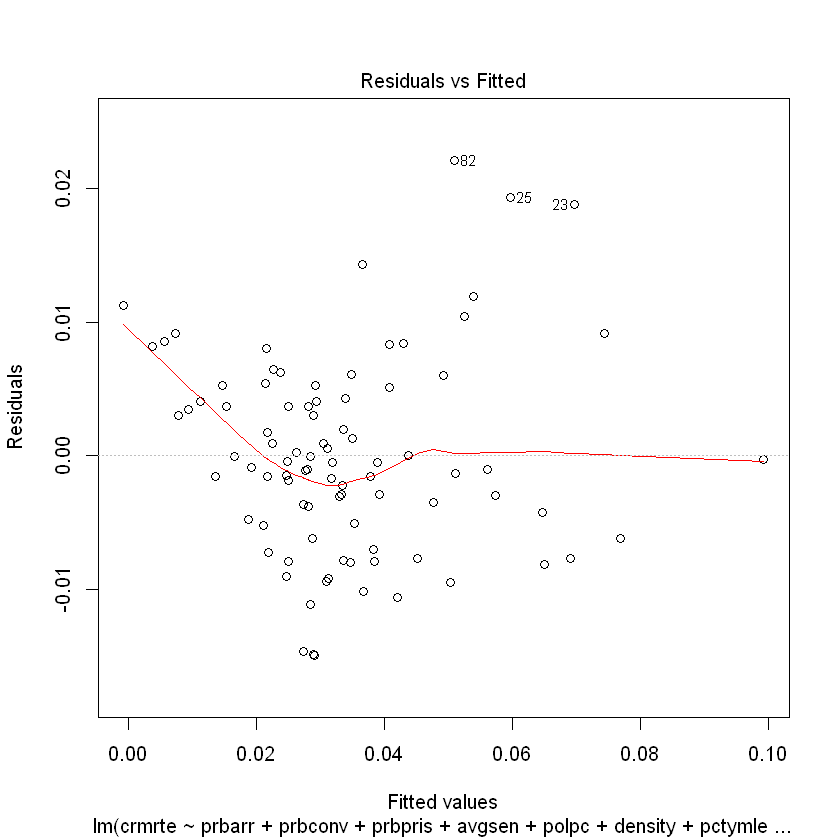

In [39]:
plot(model3, which = 1)

Similarly to our second model the red smoothing curve (representing the residual mean) begins above zero for smaller fitted values but then tracks zero for fitted values greater than 0.02. 

As before, ths slight bump to the left of the plot may indicate a slight violation of our assumption, but we can still rely on OLS asymptotics (given our large sample size), as we did for our previous models.

### MLR.5: Homoskedasticity

We analyze the Scale-Location plot of our model to check for heteroskedasticity.

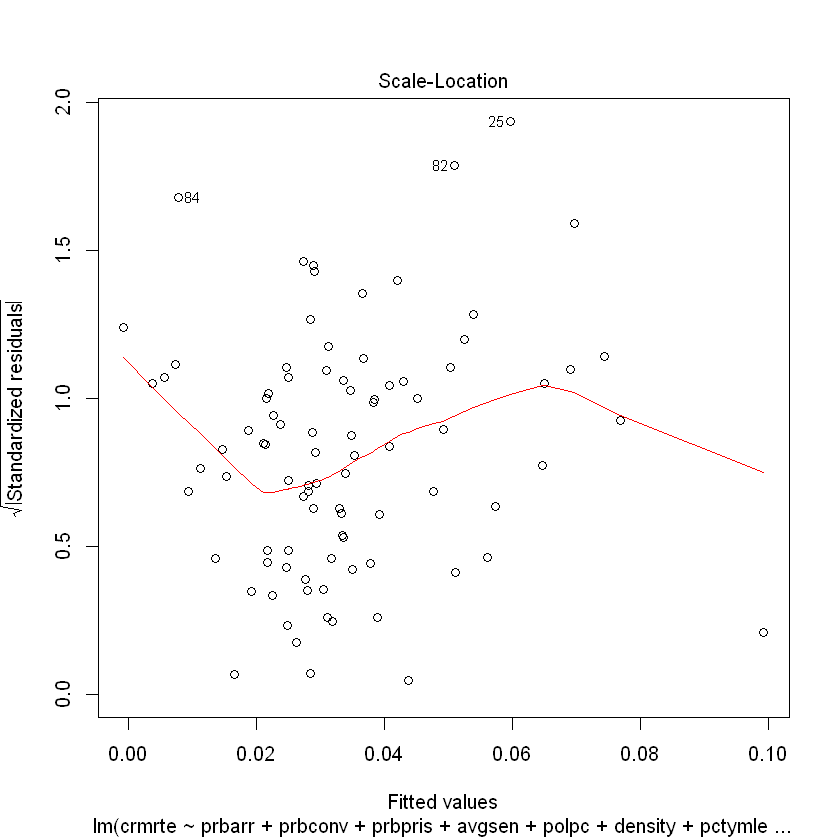

In [40]:
plot(model3, which = 3)

The scale location plot reveals a large amount of scatter, giving us evidence of heteroskedasticity. Thus the need for heteroskedasticity robust standard errors for our model. 

### Check for Influential Points

Finally, we turn to check for points with high influence by calling the plot of Residuals vs. Leverage. Again, we are looking for points with a Cook's distance greater than 1 for further investigation.

Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"Warning message in sqrt(crit * p * (1 - hh)/hh):
"NaNs produced"

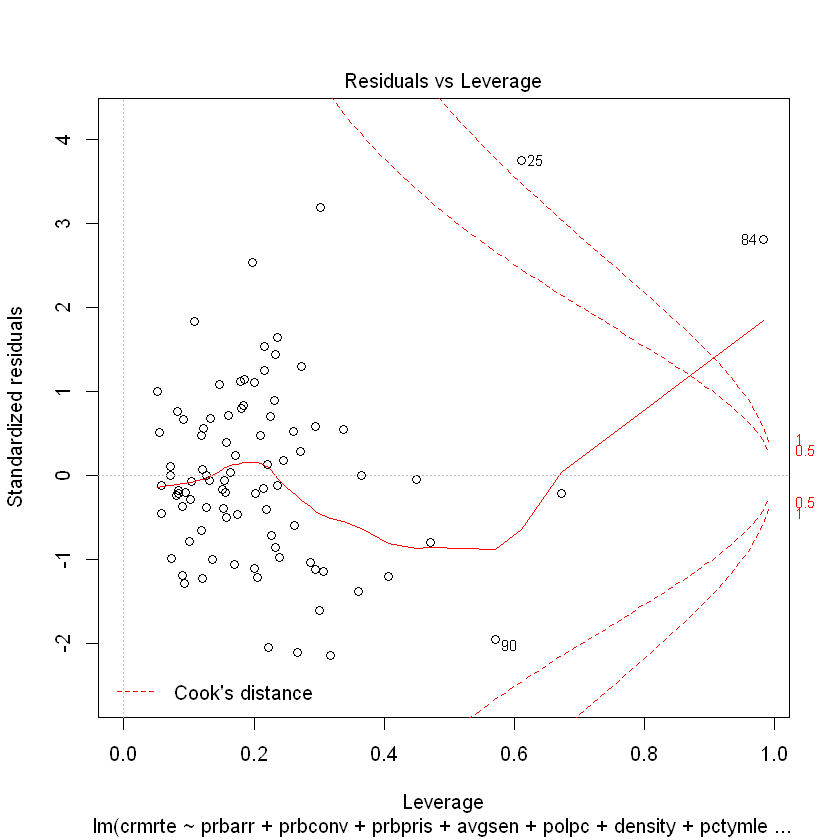

In [41]:
plot(model3, which = 5)

We have two points with Cook's distance greater than 1. This suggests that these two counties have a high leverage and influence over the model. County 25 and 94 became more influential from model 2 to model 3 due to the addition of the added economic variables to the model.

For now, we've elected to leave these outliers alone.  We're only really using our third model to evaluate how robust our initial model is.  If we had a more precise intent in mind for our third model these variables might warrant additional examination.


## Interpreting Results (Third Model)
We now consider the model's estimated parameter coefficients and standard errors (alongside those of our second model)

In [42]:
# Adjusting for heteroskedasticity
se.model3 <- sqrt(diag(vcovHC(model3)))

stargazer(model2, model3,
          type="text", keep.stat=c("n", "adj.rsq"), se=list( se.model2,se.model3), 
          single.row=TRUE, star.cutoffs = c(0.05, 0.01, 0.001))


                       Dependent variable:          
             ---------------------------------------
                             crmrte                 
                     (1)                 (2)        
----------------------------------------------------
prbarr        -0.001*** (0.0001)  -0.001*** (0.0002)
prbconv      -0.0002*** (0.00005) -0.0002** (0.0001)
prbpris       -0.00003 (0.0001)   -0.00003 (0.0001) 
avgsen         -0.0002 (0.0004)    -0.0003 (0.0005) 
polpc           7.974 (4.543)       5.285 (4.173)   
density        0.006*** (0.001)    0.005** (0.002)  
pctymle         0.064 (0.052)      0.126** (0.045)  
pctmin80      0.0004*** (0.0001)  0.0004*** (0.0001)
taxpc                              0.0002 (0.0003)  
wcon                              0.00001 (0.00003) 
wtuc                              0.00001 (0.00002) 
wtrd                               0.00002 (0.0001) 
wfir                              -0.00004 (0.00003)
wser                              -0.00000 (0

We note the new economic factors we added are not statistically significant on their own.
We check if they are jointly significant. Null hypothesis that they all have coefficients that are equal to zero.

In [43]:
linearHypothesis(model3, c("wcon=0", "wtuc=0","wtrd=0", "wfir=0",
                          "wser=0","wmfg=0","wfed=0","wsta=0","wloc=0", "polpc=0"),
                 vcov=vcovHC)

Res.Df,Df,F,Pr(>F)
81,NA,NA,NA
71,10,0.9563955,0.4885405


We cannot reject the null hypothesis that all the coefficients are equal to zero. We also note that The adjusted R-squared increased only mildly from our second model to our third (from 0.788 to 0.804). Therefore, the added variables do not seem to offer us much additional information when this model is compared to our second model. Nevertheless, we will examine how the estimated coefficients of the variables change between models 1, 2, and 3 in our regression table.

# The Regression Table

In [44]:
stargazer(model1, model2, model3,
          title="Regression Results", dep.var.labels="County Crime Rate",
          covariate.labels=c("Probability of Arrest","Probability of Conviction", 
                             "Probability of Prison Sentence", 
                             "Average Sentence Length",
                             "Police Per Capita","County Density",
                             "Percent Young Male", "Percent Minority in 1980", 
                             "Tax Per Capita", "Construction Weekly Wage", 
                             "Trans., Utility, Weekly Wage", "TRD Weekly Wage", 
                             "FIR Weekly Wage", "Service Weekly Wage", 
                             "MFG Weekly Wage", "Federal Employee Weekly Wage", 
                             "State Employee Weekly Wage", 
                             "Local Employee Weekly Wage"),
          type="text", keep.stat=c("n", "adj.rsq"), se=list(se.model1, se.model2,
          se.model3), single.row=TRUE, star.cutoffs = c(0.05, 0.01, 0.001))


Regression Results
                                                   Dependent variable:                    
                               -----------------------------------------------------------
                                                    County Crime Rate                     
                                       (1)                 (2)                 (3)        
------------------------------------------------------------------------------------------
Probability of Arrest          -0.001*** (0.0002)   -0.001*** (0.0001)  -0.001*** (0.0002)
Probability of Conviction      -0.0003*** (0.0001) -0.0002*** (0.00005) -0.0002** (0.0001)
Probability of Prison Sentence   0.0001 (0.0002)    -0.00003 (0.0001)   -0.00003 (0.0001) 
Average Sentence Length          -0.0003 (0.001)     -0.0002 (0.0004)    -0.0003 (0.0005) 
Police Per Capita               12.197** (3.932)      7.974 (4.543)       5.285 (4.173)   
County Density                                       0.006*** (0.001) 

We note that in models 1, 2, and 3, we have many significant variables. In all models, the probability of arrest and probability of conviction are significant in a negative direction. This has practical significance as increasing the probability of arrest would deter others from conducting bad behavior due to the fear or being caught. 

In models 2 and 3, county density and percent minority in 1980 are significant, despite the added variables in model 3, indicating that these variables are relevant for the explanation of crime rates.

In all three models, the probability of arrest, probability of conviction, county density, and percent minority in 1980 regression coefficients stayed nearly the same despite the addition of more variables, so we believe these variables are relevant in our model's prediction of crime rate. The added variables then, helped predict crime rate in our model by reducing some of the omitted variable bias.

We also note that there are three interesting outcomes from the regression tables:

1. Police per capita is statistically significant in model 1, but not in models 2 or 3. Additionally, the estimated coefficient decreases in value for model 2 and model 3, yet has a higher standard error in models 2 and 3, then model 1. The positive linear regression coefficient for police per capita indicates it's correlation with other variables. The decrease between 30-40% in the linear regression coefficient value from model 1 to model 2 and model 2 to model 3, indicates that an omitted variable bias is likely present that is currently being seen in the Police per capita variable.

2. All economic-related explanatory variables were not statistically significant in model 3, which indicates that the addition of average wages or tax per capita for each county, does not indicate any explanation of county crime rates.

3. Finally, the regression coefficient for percent young male is not statistically significant in model 2, but exhibits significance for model 3. This revelation indicates that although the economic-explanatory variables may not be relevant to predicting crime rate, percent young male is significant while these variables are present so perhaps there is another omitted variable bias present that affects percent young male in predicting crime rates, but also statistically significant.

In examining our data, we believe that a variable reduction approach (starting with many variables and remove the insignificant ones in further models), would remove the probability of prison sentence and the average sentence length. We find it surprising that these variables do not appear to predict crime rates, as they tend to be a critical portion of the judicial incarceration system.

# Omitted Variables

As discussed in the previous section on the regression table, we believe that there may be omitted variable bias from model 1 to model 2 and from model 2 to model 3. The decrease in police per capita from model 1 to model 2 indicates that the demographic explanatory variables were omitted variables from model 1. When we get to model 3, none of the added economic-related wages were statistically significant indicating that none of these variables are omitted variables from model 2. However, there may be another omitted variable out there that affects percent young male, since that variable becomes statisticall significant in model 3 with the addition of the economic variables. We believe that this could be explained by a variable we may not have information for, such as unemployment rates which tend to influence young males to make more law-breaking decisions.

We also suspect there are two other potential omitted variables that we do not have data for to explain some of the variance: 1) probability of arrest given a past sentence and 2) police department funding. In both cases, we believe these variables have a relation to both crime rate and the variables through model 1 to 3 such as probability of arrest, police per capita, tax per capita, and so on. Since we cannot detect omitted variable bias without data measures on the omitted variables, we can only argue that our regression equation and estimators for regression coefficients of model 3 are likely vulnerable to omitted variable bias of our identified two potentially omitted variables, which is a limitation from our given data.

For probability of arrest given a past sentence, we believe this variable would be in a positive direction in influencing crime rate, because it is known that the impacts of incarceration vary from county to county, but generally has had an unexpected effect of increasing crime due to the inability to reintegrate back into society. Therefore, this omitted variable has a possibility of being correlated with the crime rate due to one person committing more than one crime which would impact the county average for probability of arrest, probability of conviction, and probability of sentence. 

For police department funding, we believe this variable may be in a negative direction in influencing crime rate, because as police departments receive more funding, they may become more effective in keeping law and order. This omitted variable has a possibility of being correlated with the crime rate since more effective police officers may deter crime and may correlate with police per capita and weekly wage of federal/state employees, which are relating how much money is available to the police department. 

We mention these potentially omitted variables, because the high value of police per capita from models 1, 2, and 3 indicate that there is an omitted variable bias that is being captured in that regression coefficient value. In summary, we address that our models has three potentially omitted variables: unemployment rates, probability of arrest given a past arrest and police department funding. Without the data, we cannot determine if the variables are related to both crime rate and some of the independent variables, but we can infer that this may be a limitation of our model. 

# Conclusion 

In conclusion, we explored the crime_v2.csv data set from Cornwell and Trumball and created three regression models to examine crime rate as a linear combination of policy-related variables, demographic explanatory variables, and economic related variables. Our first model focused on policy-related variables that we can directly impact. Our second model built upon our first model with demographic explanatory variables. Finally, we examined the addition of weekly wages and tax per capita by adding them to our third model. 

This was done to answer the our research questions (and subquestions) about the impact of the probability of arrest, the probability of conviction, the probability of a prison sentence, average length of a prison sentence, and police per capita on a county's crime rate. Having analyzed all three models, we return to these questions now.

- Does increasing the probability of arrest, conviction, and a prison sentence decrease the crime rate (by deterring potential criminals)?

In all three models we reject the null hypothesis that the parameter coefficients of the probability of arrest and the probability of conviction are equal to zero. Increases in each of these two probabilities are associated with decreases in crime rate.

In all three models we fail to reject the null hypothesis that the parameter coefficient for the probability of a prison sentence is equal to zero. 

- Does lengthening prison sentences lower crime rate (again, by deterring potential criminals)?

In all three regression models, we fail to reject the null hypothesis that the parameter coefficient of average sentence length is equal to zero. 

- Does increasing police presence in a county reduce the crime rate?

In our first model, we rejected the null hypothesis that the parameter coefficient on police per capita is equal to zero. However, when we control for demographic and economic factors in our second and third models. we failed  to reject the null hypothesis that the parameter coefficient of police per capita is equal to zero. We believe police per capita is positively correlated with demographic factors such as density, percent minority, and percent young male  that are themselves positively correlated with crime rate. Indeed, we note that these variables had statistically significant estimated parameter coefficients in our later models.

Therefore, we recommend that our client focuses on two policy proposals for their political campaign:

1. Investigate public policy that affects police officers and judges to increase the probability of arrest and probability of conviction. By increasing these rates, our second model predicts that crime rate will decrease. Since the regression coefficients for these variables in our second model are -0.001 and -0.0002 respectively, we would not make a direct public policy recommendation, but recommend that a more thorough investigation in each county’s current law enforcement and judge practices could be a low-hanging fruit to lower crime rate. This could be a simple information session for each county’s police chiefs and judges or a state-led investigation by the inspector general. Each county may have different practices and therefore a policy focusing on establishing effective standardized county practices may have the best effect on crime reduction.


2.   Finally, we recommend that the political campaign considers the effect of average sentences. The probability of prison sentence and average sentence variables were not statistically significant, indicating these variables in our model do not have a strong effect on crime rate. Therefore, given our data and our analysis, it is possible for the political campaign to address some glaring incarceration public policy concerns. Pop culture and local internet gossip refers that the “Three-Strikes Law” is unjust or even that the difference between prison sentences of a couple days to a couple months is difficult to quantify. Our model suggests that reducing prison sentences or changing incarceration rates would have little effect on crime rates, since they are not statistically significant compared to the other variables. Therefore, we recommend a more thorough investigation on reducing prison sentence lengths for types of crime, as this may have a positive voter appeal and also reduce a flawed public policy of high prison sentences. 
